In [1]:
import torch
import numpy as np

from counterfactuals.datasets.blobs import BlobsDataset
from counterfactuals.discriminative_models.logistic_regression import (
    MultinomialLogisticRegression,
)
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.cf_methods.ppcef import PPCEF
from counterfactuals.metrics.metrics import evaluate_cf

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

/home/lukasz/miniconda3/envs/cf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
device = "cpu"

In [3]:
dataset = BlobsDataset("../data/blobs.csv")
train_dataloader = dataset.train_dataloader(
    batch_size=128,
    shuffle=True,
    noise_lvl=0,
)
test_dataloader = dataset.test_dataloader(batch_size=128, shuffle=False)

In [4]:
disc_model = MultinomialLogisticRegression(
    input_size=dataset.X_test.shape[1], target_size=3
)
disc_model.fit(dataset.train_dataloader(128, True), epochs=100)
preds = disc_model.predict(dataset.X_test)
print(classification_report(dataset.y_test.flatten(), preds.numpy()))

Epoch 99, Loss: 0.0201: 100%|██████████| 100/100 [00:01<00:00, 92.67it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



In [5]:
gen_model = MaskedAutoregressiveFlow(
    features=dataset.X_test.shape[1],
    hidden_features=4,
    context_features=1,
    device=device
)
gen_model.fit(train_dataloader, test_dataloader, num_epochs=200)

Epoch 199, Train: 3.6515, test: 3.6738: 100%|██████████| 200/200 [00:09<00:00, 20.39it/s]


In [6]:
y_preds = []
with torch.no_grad():
    for x, y in zip(dataset.X_test, dataset.y_test):
        x = torch.from_numpy(x).view(1, -1)
        y_zero = torch.Tensor([0])
        y_one = torch.Tensor([1])
        y_two = torch.Tensor([2])
        y_pred = np.argmax(
            [
                gen_model(x, y_zero).item(),
                gen_model(x, y_one).item(),
                gen_model(x, y_two).item(),
            ]
        )
        y_preds.append(y_pred)
print(classification_report(dataset.y_test.flatten(), y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



In [7]:
# class MulticlassDiscLoss(torch.nn.modules.loss._Loss):
#     def __init__(
#         self, size_average=None, reduce=None, reduction: str = "mean", eps=0.02
#     ) -> None:
#         super().__init__(size_average, reduce, reduction)
#         self.eps = eps

#     def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
#         return torch.nn.functional.cross_entropy(input, target.view(-1))
    
class MulticlassDiscLoss(torch.nn.modules.loss._Loss):
    def __init__(
        self, size_average=None, reduce=None, reduction: str = "mean", eps=0.02
    ) -> None:
        super().__init__(size_average, reduce, reduction)
        self.eps = eps

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        one_hot = torch.eye(3)[target][:,0,:]
        dot_product = torch.sum(input*one_hot, dim=1)
        return torch.mean(dot_product - torch.max(input, dim=1).values)

In [8]:
loss_fn = MulticlassDiscLoss()

In [9]:
cf = PPCEF(
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=loss_fn,
    neptune_run=None,
    device="cpu"
)

In [10]:
delta = torch.median(gen_model.predict_log_prob(train_dataloader))
cf_dataloader = dataset.test_dataloader(batch_size=1024, shuffle=False)
Xs_cfs, Xs, ys_orig, loss_components = cf.search_batch(
    cf_dataloader,
    epochs=5000,
    patience=200,
    lr=0.005,
    alpha=100,
    delta=delta,
)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:09<00:00,  9.69s/it]


In [11]:
loss_components.keys()

dict_keys(['cf_search/loss', 'cf_search/dist', 'cf_search/max_inner', 'cf_search/loss_disc'])

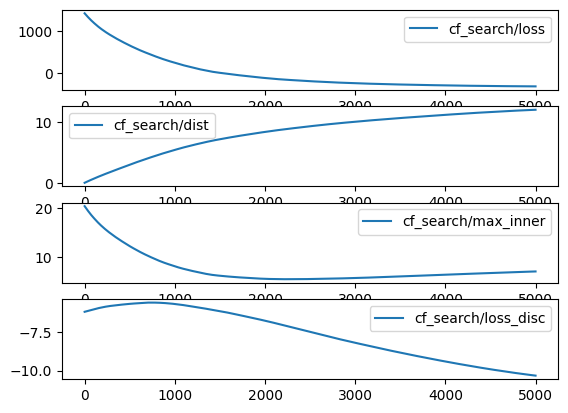

In [12]:
for i, (k, v) in enumerate(loss_components.items(), 1):
    plt.subplot(4, 1, i)
    plt.plot(v, label=k)
    plt.legend()

In [13]:
metrics = evaluate_cf(
    gen_model=gen_model,
    disc_model=disc_model,
    X=Xs,
    X_cf=Xs_cfs,
    model_returned=np.ones(Xs_cfs.shape[0], dtype=bool),
    categorical_features=dataset.categorical_features,
    continuous_features=dataset.numerical_features,
    X_train=dataset.X_train,
    y_train=dataset.y_train.reshape(-1),
    X_test=dataset.X_test,
    y_test=dataset.y_test,
    delta=delta.numpy(),
)

(150, 2)


In [14]:
metrics

{'model_returned_smth': 1.0,
 'valid_cf_disc': 0.3333333333333333,
 'dissimilarity_proximity_categorical_hamming': nan,
 'dissimilarity_proximity_categorical_jaccard': 0.0,
 'dissimilarity_proximity_continuous_manhatan': 15.012218650262803,
 'dissimilarity_proximity_continuous_euclidean': 11.981763675780403,
 'dissimilarity_proximity_continuous_mad': 3.0212561150391894,
 'distance_l2_jaccard': 11.981763675780403,
 'distance_mad_hamming': nan,
 'sparsity': 1.0,
 'valid_cf_gen': 0.3466666666666667,
 'flow_log_density_cfs_zero': -13.720065,
 'flow_log_density_cfs_one': -15.226683,
 'flow_log_density_cfs': -14.473372,
 'flow_log_density_xs_zero': -34.14543,
 'flow_log_density_xs_one': -15.244014,
 'flow_log_density_xs': -24.694721,
 'flow_prob_condition_acc': 0.16333333333333333}